## Problem Statement - RLS
----
Following data collected at equal time interval

| Current (A) | Voltage (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

Fit a linear model $V = RI + b$ using recursive LS and compare with batch solution.

It is also given that the current values are known exactly, and that the voltage measurements are corrupted by additive, independent and identitically distributed zero-mean Gaussian noise with a standard deviation of $0.15~V$ (i.e., a variance of $0.0225 ~ V^2$).

## Python Code
----
As before, the first step is to import the neccesary Python modules and load the current values and voltage measurements into NumPy arrays:

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

Assume $\hat{R}$ follows a Gaussian or normal distribution with a mean of $4~\Omega$ and a standard deviation of $3~ \Omega$ (i.e., a variance of $9~\Omega^{2}$). 
Similarly, your intial guess is that $\hat{b}$ should also follow a normal distribution with a mean of $0~V$ and a variance of $0.2~V^{2}$.

$$\hat{R} \sim \mathcal{N}(4, 9.0),~~\hat{b} \sim \mathcal{N}(0, 0.2)$$

In [2]:
I = np.array([[0.2, 0.3, 0.4, 0.5, 0.6]]).T
V = np.array([[1.23, 1.38, 2.06, 2.47, 3.17]]).T
print("Current \n",I,"\nVoltage \n", V)

Current 
 [[0.2]
 [0.3]
 [0.4]
 [0.5]
 [0.6]] 
Voltage 
 [[1.23]
 [1.38]
 [2.06]
 [2.47]
 [3.17]]


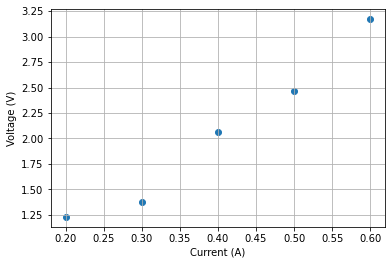

In [3]:
plt.scatter(I, V)
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.show()

## Estimating the Slope and Offset Parameters
----
### Batch Estimator
Before implementing the recursive least squares estimator, let's examine the parameter estimates given by the batch least squares method used in the previous assignment. This time, you will be fitting a model which contains an offset $y = Rx + b$. This result can be used later for comparison.

[[0.2 1. ]
 [0.3 1. ]
 [0.4 1. ]
 [0.5 1. ]
 [0.6 1. ]]
The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:
4.970000000000002
0.0739999999999999


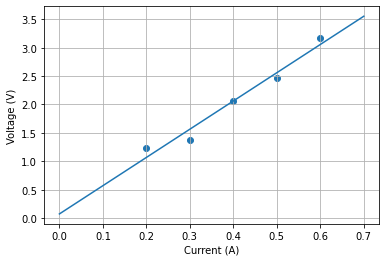

In [4]:
## Batch Solution
# X(LS)=Inv(H_Transpose.H)(H_Transpose)(y)

H = np.ones((5, 2))
H[:, 0] = I.T
print(H)
x_ls = inv(H.T.dot(H)).dot(H.T).dot(V)
print('The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:')
print(x_ls[0,0])
print(x_ls[1,0])

# Plot line.
I_line = np.arange(0, 0.8, 0.1).reshape(8, 1) #Range taken from the given data (0.2 to 0.8 in this case)
V_line = x_ls[0,0]*I_line + x_ls[1,0] #V=R*I+b size of I

plt.scatter(I, V)
plt.plot(I_line, V_line)
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.show()

As expected, the offset parameter $\hat{b}$ is near zero, while $\hat{R}$ closely approximates the true resistance value of $R = 5~\Omega$.

### Recursive Estimator
Now let's try to implement the least squares method recursively! Recall the steps described in Module 1, Lesson 2 - "Recursive Least Squares": 

**Initialize the parameter and covariance estimates**:

----
$$
\hat{\mathbf{x}}_0 = E\left[\mathbf{x}\right],\quad \mathbf{P}_0 = E\left[(\mathbf{x} - \hat{\mathbf{x}}_0)(\mathbf{x} - \hat{\mathbf{x}}_0)^T\right]
$$

In [5]:
## Recursive Solution

# Assume initial values of the state [2x1] R and b.
x_k=np.array([[4.0], [0.0]])
#print(x_k)

#Assume initial Process Covariance matrix [2x2]. Off-diangonal be zeros.
P_k=np.array([[9.0, 0], [0, 0.2]])

# Our voltage measurement variance (denoted by R, don't confuse with resistance).
R_k = np.array([[0.0225]])
#print(x_k, P_k, R_k)

# Initialize the matrices to store estimates after every step.
num_meas = I.shape[0] # Try I.shape
#print ("Count ", num_meas) 

x = np.zeros((num_meas + 1, 2)) # +1 to store initial matrix
P = np.zeros((num_meas + 1, 2, 2)) # +1 to store initial matrix
#print("Shape of x", x.shape, "\n X matrix \n",x)
#print("Shape of P", P.shape, "\n P matrix \n",P)

# Assign initial x_k (k=0) to first row of x matrix. Let us check the shape
#print("Shape of x ", x.shape, ", x_k matrix ",x_k.shape, " and Transpose of x_k ", x_k.T.shape)

x[0] = x_k.T
P[0] = P_k
print("X ",x)



X  [[4. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


**For every measurement k**:

----
  * Calculate the gain term: $$\mathbf{K}_k = \mathbf{P}_{k-1}\mathbf{H}_k^T\left(\mathbf{H}_k\mathbf{P}_{k-1}\mathbf{H}_k^T + \mathbf{R}_k\right)^{-1}$$
  * Update the parameter estimate: $$\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k-1} + \mathbf{K}_k\left(\mathbf{y}_k - \mathbf{H}_k\hat{\mathbf{x}}_{k-1}\right)$$
  * Update the covariance estimate: $$\mathbf{P}_k = \left(\mathbf{I} - \mathbf{K}_k\mathbf{H}_k\right)\mathbf{P}_{k-1}$$
  
In this case, the initial parameter vector $\hat{\mathbf{x}}_0$ should contain $\hat{R}$ and $\hat{b}$. 

In [6]:
# Iterate over all the available measurements.
for k in range(num_meas):
    # Construct H_k (Jacobian).
    H_k = np.array([H[k]])
    #print("Hk",H_k)

    # Construct K_k (gain matrix). 
    K_k=P_k.dot(H_k.T).dot(inv(H_k.dot(P_k.dot(H_k.T))+R_k))
    #print(K_k)
    
    # Update our estimate.
    x_k = x_k+K_k.dot(V[k]-H_k.dot(x_k))
 
    # Update uncertainty (covariance) of the Process/Model 
    P_k = K_k.dot(H_k)
    #print(P_k)
    
    # Store the intermediate result of Resistance and Intercept.
    P[k + 1] = P_k
    x[k + 1] = x_k.T
    #print(x_k)
    
print('The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:')
print(x_k[0, 0])
print(x_k[1, 0])
#print(P)

The slope and offset parameters of the best-fit line (i.e., the resistance and offset) are [R, b]:
5.078171344233823
0.11979681602598038


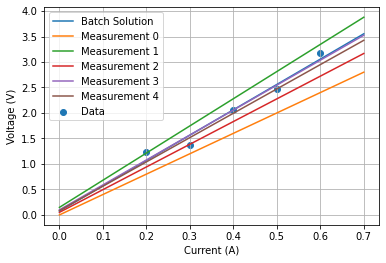

In [7]:
plt.scatter(I, V, label='Data')
plt.plot(I_line, V_line, label='Batch Solution')
plt.xlabel('Current (A)')
plt.ylabel('Voltage (V)')
plt.grid(True)

I_line = np.arange(0, 0.8, 0.1).reshape(8, 1)

for k in range(num_meas):
    V_line = x[k, 0]*I_line + x[k, 1]
    plt.plot(I_line, V_line, label='Measurement {}'.format(k))
plt.legend()
plt.show()